<a href="https://colab.research.google.com/github/nisargabhaskar/3DSceneRec/blob/main/3D_Scene_Construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from PIL import Image

img = np.array(Image.open('/content/drive/MyDrive/OST_004.png')) 
im = np.array(Image.open('/content/drive/MyDrive/OST_004.png').convert('L'))#you can pass multiple arguments in single line
print(type(img))

gr_im= Image.fromarray(im).save('gr_OST_004.png')

<class 'numpy.ndarray'>


MiDas Model for depth prediction

In [ ]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 4.1 MB/s 


In [ ]:
import torch
import matplotlib.pyplot as plt

In [ ]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-midas-2f21e586.pt" to /root/.cache/torch/hub/checkpoints/dpt_large-midas-2f21e586.pt


  0%|          | 0.00/1.28G [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU(approximate=none)
            (drop1): Dropout(p=0.0, inplace=F

In [ ]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
input_batch = transform(img).to(device)

In [ ]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

<class 'numpy.ndarray'>


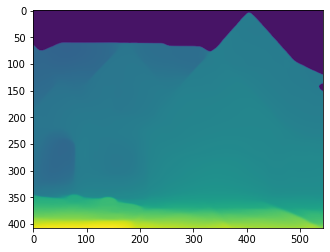

In [ ]:
print(type(output))
plt.imshow(output)
plt.imsave("out_OST_004.png",output)

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

In [ ]:
LIST_IMAGES = ['/content/drive/MyDrive/OST_004.png', '/content/gr_OST_004.png']
RAW_IMAGES = []

for IMG in LIST_IMAGES:
    RAW = cv.imread(IMG)
    RAW_IMAGES.append(RAW)

(-0.5, 543.5, 407.5, -0.5)

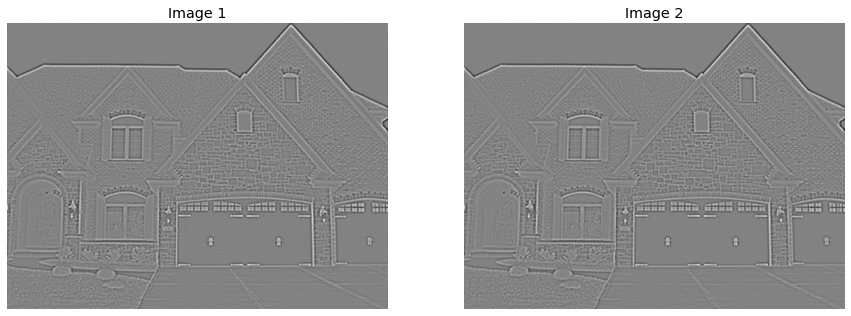

In [ ]:
# Create new list of images with Gaussian Blur
GAUSSIAN_IMAGES = []

# Compute Gaussian Blur
for IMG in RAW_IMAGES:
    IMAGE = cv.cvtColor(IMG, cv.COLOR_BGR2GRAY)
    BLUR = cv.GaussianBlur(IMAGE, (5, 5), 0)
    GAUSSIAN_IMAGES.append(BLUR)

# Create new list of images with Laplacian Edge Detection
EDGES_IMAGES = []

# Compute Laplacian Edge Detection
for IMG in GAUSSIAN_IMAGES:
    EDGES = cv.Laplacian(IMG, 5)
    EDGES_IMAGES.append(EDGES)

# Plot new images
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
ax = axes.ravel()
ax[0] = plt.subplot(2, 2, 1)
ax[1] = plt.subplot(2, 2, 2)


ax[0].imshow(EDGES_IMAGES[0], cmap=plt.cm.gray)
ax[0].set_title('Image 1')
ax[0].axis('off')

ax[1].imshow(EDGES_IMAGES[1], cmap=plt.cm.gray)
ax[1].set_title('Image 2')
ax[1].axis('off')


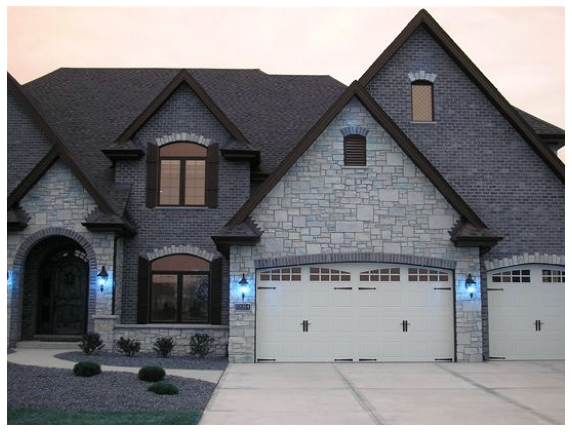

In [ ]:
# Convert images to array
laps = np.asarray(EDGES_IMAGES)

# Create new image
FOCUS_IMAGE = np.zeros(shape=RAW_IMAGES[0].shape, dtype=RAW_IMAGES[0].dtype)

# Select best pixels
for y in range(RAW_IMAGES[0].shape[0]):
  for x in range(RAW_IMAGES[0].shape[1]):
    yxlaps = abs(laps[:, y, x])
    index = (np.where(yxlaps == max(yxlaps)))[0][0]
    FOCUS_IMAGE[y,x] = RAW_IMAGES[index][y,x]

# INFOCUS = cv.imwrite('infocus_img.jpg', FOCUS_IMAGE)

# Plot in-focus images
plt.figure(figsize=(10, 10))
plt.imshow(FOCUS_IMAGE)
plt.axis('off')
plt.show()
plt.imsave('infocus_1.png',FOCUS_IMAGE)

Create 3d point cloud

In [ ]:
pip install pyntcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 4.3 MB/s 


In [ ]:
pip install open3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 408.6 MB 31 kB/s 
     |████████████████████████████████| 3.1 MB 40.2 MB/s 
     |████████████████████████████████| 8.8 MB 39.4 MB/s 
     |████████████████████████████████| 596 kB 71.2 MB/s 
     |████████████████████████████████| 1.1 MB 52.5 MB/s 
     |████████████████████████████████| 344 kB 48.9 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 423 kB 47.6 MB/s 
     |████████████████████████████████| 9.7 MB 23.9 MB/s 
     |████████████████████████████████| 1.2 MB 58.4 MB/s 
     |████████████████████████████████| 561 kB 68.5 MB/s 
     |████████████████████████████████| 80 kB 9.3 MB/s 
     |████████████████████████████████| 132 kB 57.8 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 133 kB 55.0 MB/s 
     |███████████████████████████████

In [ ]:
!python /content/drive/MyDrive/Point_Cloud_Generation.py -i /content/drive/MyDrive/OST_004.png -d /content/out_OST_004.png 

In [ ]:
from google.colab import files
files.download('Ptcld.ply')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>